In [2]:
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 6.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numba]━━━━━ 1/2 [numba]


In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from multiprocessing import Pool

In [10]:
np.random.seed(42)

# Constants
n_nodes = 10
n_sources = 3
hours = 24

# Node metadata
node_ids = [f"Node_{i+1}" for i in range(n_nodes)]
distances = np.random.uniform(1, 10, n_nodes)  # km from source hub
criticality = np.random.choice([1, 2, 3], size=n_nodes, p=[0.5, 0.3, 0.2])  # 1=normal, 3=critical

# Demand: base + sinusoidal day pattern + random noise
hour_vector = np.arange(hours)
base_demand = np.random.randint(100, 200, size=n_nodes).reshape(-1, 1)
demand = base_demand + 50*np.sin(np.pi * hour_vector / 12) + np.random.normal(0, 10, (n_nodes, hours))
demand = np.clip(demand, 80, None).astype(int)

# Source: solar peaks at noon, wind random, hydro constant
solar = 600 * np.sin(np.pi * hour_vector / 24)**2 + np.random.normal(0, 30, hours)
wind = np.random.normal(400, 100, hours)
hydro = np.full(hours, 500)

solar = np.clip(solar, 0, 700)
wind = np.clip(wind, 100, 700)

capacity = np.vstack([hydro, solar, wind]).astype(int)

# Source cost (varies over peak hours: 18-21)
base_cost = np.array([0.08, 0.05, 0.12])  # hydro, solar, wind
cost = np.tile(base_cost.reshape(-1, 1), (1, hours))
peak_hours = (hour_vector >= 18) & (hour_vector <= 21)
cost[:, peak_hours] += 0.05  # surcharge

# Transmission loss based on distance
loss = 0.02 + (distances / 20)  # 2% + distance-based

# Pack data
grid_data = {
    "demand": demand,
    "capacity": capacity,
    "cost": cost,
    "loss": loss,
    "criticality": criticality,
    "nodes": node_ids
}


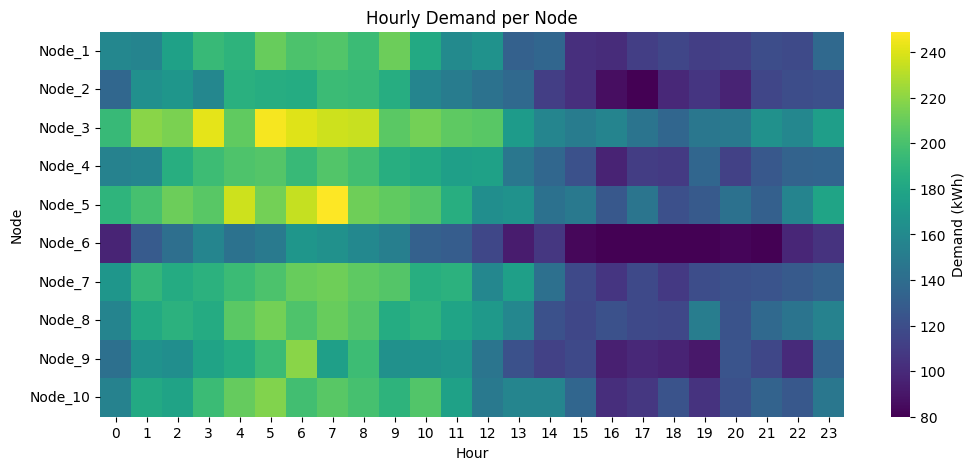

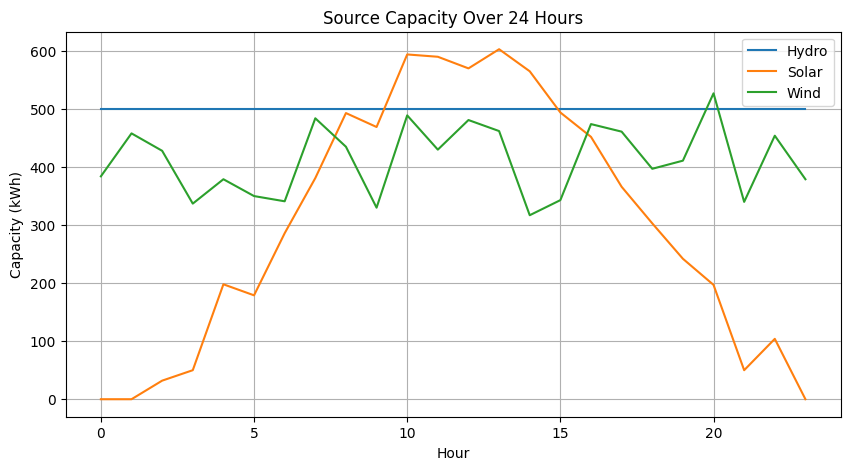

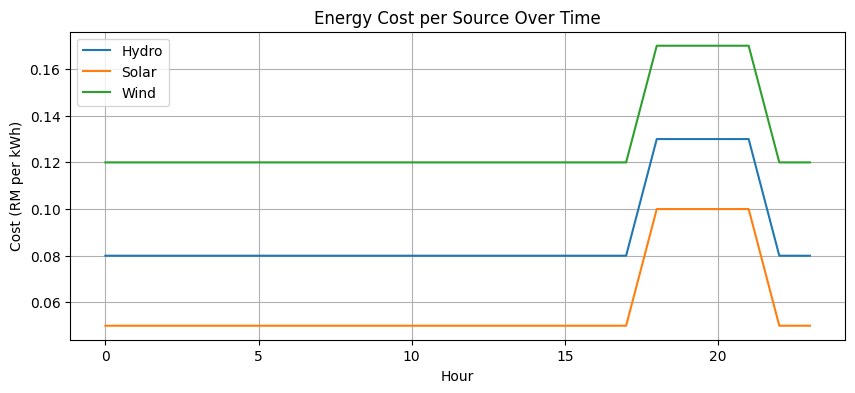

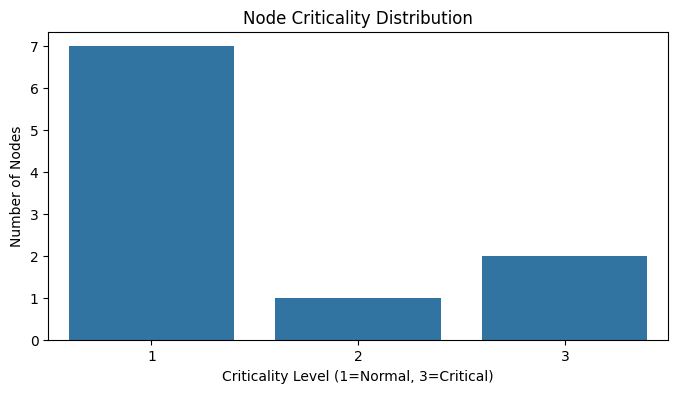

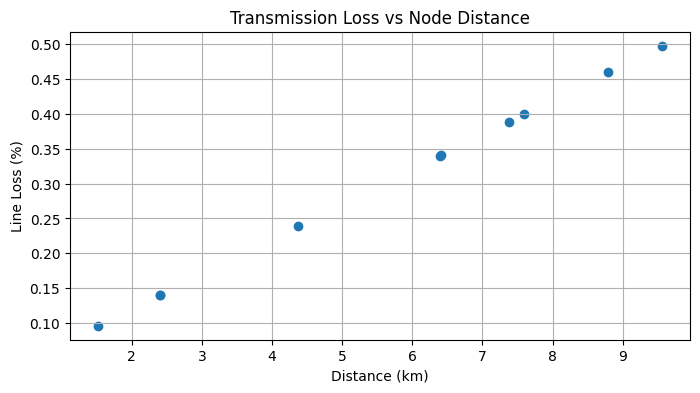

In [11]:
# Demand heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(grid_data["demand"], cmap="viridis", cbar_kws={'label': 'Demand (kWh)'})
plt.title("Hourly Demand per Node")
plt.xlabel("Hour")
plt.ylabel("Node")
plt.yticks(np.arange(n_nodes)+0.5, grid_data["nodes"], rotation=0)
plt.show()

# Source capacity
plt.figure(figsize=(10, 5))
plt.plot(grid_data["capacity"][0], label='Hydro')
plt.plot(grid_data["capacity"][1], label='Solar')
plt.plot(grid_data["capacity"][2], label='Wind')
plt.title("Source Capacity Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Capacity (kWh)")
plt.legend()
plt.grid(True)
plt.show()

# Source cost
plt.figure(figsize=(10, 4))
plt.plot(grid_data["cost"][0], label='Hydro')
plt.plot(grid_data["cost"][1], label='Solar')
plt.plot(grid_data["cost"][2], label='Wind')
plt.title("Energy Cost per Source Over Time")
plt.xlabel("Hour")
plt.ylabel("Cost (RM per kWh)")
plt.legend()
plt.grid(True)
plt.show()

# Criticality bar
plt.figure(figsize=(8, 4))
sns.countplot(x=grid_data["criticality"])
plt.title("Node Criticality Distribution")
plt.xlabel("Criticality Level (1=Normal, 3=Critical)")
plt.ylabel("Number of Nodes")
plt.show()

# Loss vs distance
plt.figure(figsize=(8, 4))
plt.scatter(distances, grid_data["loss"])
plt.title("Transmission Loss vs Node Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Line Loss (%)")
plt.grid(True)
plt.show()


In [28]:
class GA_EnergyOptimizer:
    def __init__(self, demand, capacity, cost, loss, criticality, nodes, pop_size=100, mutation_rate=0.01):
        self.demand = demand
        self.capacity = capacity
        self.cost = cost
        self.loss = loss
        self.criticality = criticality
        self.nodes = nodes
        self.n_nodes, self.hours = demand.shape
        self.n_sources = capacity.shape[0]
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.chrom_len = self.n_nodes * self.n_sources * self.hours

    def initialize_population(self):
        pop = np.random.rand(self.pop_size, self.chrom_len)
        print(f"Population shape: {pop.shape}")  # Should print (200, 720)
        return pop


    def decode_chromosome(self, chrom):
        return chrom.reshape((self.n_nodes, self.n_sources, self.hours))

    def fitness(self, chrom):
        allocation = self.decode_chromosome(chrom)
        total_cost = 0
        penalty = 0

        for h in range(self.hours):
            src_supply = np.zeros(self.n_sources)
            for node in range(self.n_nodes):
                alloc = allocation[node, :, h]
                node_demand = self.demand[node, h] / (1 - self.loss[node])
                node_supplied = np.sum(alloc)
                penalty += max(0, abs(node_supplied - node_demand)) * 10  # demand fulfillment
                total_cost += np.dot(alloc, self.cost)

                src_supply += alloc

            for s in range(self.n_sources):
                if src_supply[s] > self.capacity[s, h]:
                    penalty += (src_supply[s] - self.capacity[s, h]) * 20  # overcapacity penalty

        return -(total_cost + penalty)  # minimize cost + penalties

In [24]:
def parallel_fitness(pop, grid_data):
    args_list = [
        (chrom, grid_data["demand"], grid_data["capacity"], grid_data["cost"],
         grid_data["loss"], grid_data["criticality"])
        for chrom in pop
    ]

    with Pool() as p:
        fitness_scores = p.map(fitness_wrapper, args_list)

    return np.array(fitness_scores)

In [20]:
def selection(pop, fitness):
    idx = np.argsort(fitness)[-2:]  # Select top 2
    return pop[idx]

def crossover(p1, p2):
    mask = np.random.rand(*p1.shape) < 0.5
    return np.where(mask, p1, p2)

def mutate(child, rate=0.01):
    mutation = np.random.rand(*child.shape) < rate
    child[mutation] = np.random.rand(np.sum(mutation))
    return child

In [23]:
def fitness_wrapper(args):
    chrom, demand, capacity, cost, loss, criticality = args
    n_nodes, hours = demand.shape
    n_sources = capacity.shape[0]

    # Reshape
    try:
        allocation = chrom.reshape((n_nodes, n_sources, hours))
    except:
        print("Chrom shape:", chrom.shape)
        raise

    total_cost = 0
    penalty = 0

    for h in range(hours):
        src_supply = np.zeros(n_sources)
        for node in range(n_nodes):
            alloc = allocation[node, :, h]
            node_demand = demand[node, h] / (1 - loss[node])
            node_supplied = np.sum(alloc)

            penalty += max(0, abs(node_supplied - node_demand)) * 10 * criticality[node]
            total_cost += np.dot(alloc, cost[:, h])
            src_supply += alloc

        for s in range(n_sources):
            if src_supply[s] > capacity[s, h]:
                penalty += (src_supply[s] - capacity[s, h]) * 20

    return -(total_cost + penalty)  # Negative = minimize

In [25]:
def run_ga(generations=50):
    ga = GA_EnergyOptimizer(**grid_data, pop_size=200)
    population = ga.initialize_population()
    best_fitness_per_gen = []

    for gen in range(generations):
        fitness = parallel_fitness(population, grid_data)
        best_fitness_per_gen.append(np.max(fitness))
        top = selection(population, fitness)

        new_pop = []
        for _ in range(len(population)):
            child = crossover(*top)
            child = mutate(child, ga.mutation_rate)
            new_pop.append(child)
        population = np.array(new_pop)

        if gen % 10 == 0:
            print(f"Generation {gen}: Best fitness = {best_fitness_per_gen[-1]}")

    return best_fitness_per_gen

Generation 0: Best fitness = -917637.4292557398
Generation 10: Best fitness = -916795.2461445082
Generation 20: Best fitness = -916351.0283622326
Generation 30: Best fitness = -915983.1276056652
Generation 40: Best fitness = -915743.1163258238
Generation 50: Best fitness = -915497.9889955911
Generation 60: Best fitness = -915293.6907216752
Generation 70: Best fitness = -915121.7111741627
Generation 80: Best fitness = -914996.5669920299
Generation 90: Best fitness = -914884.0940518467


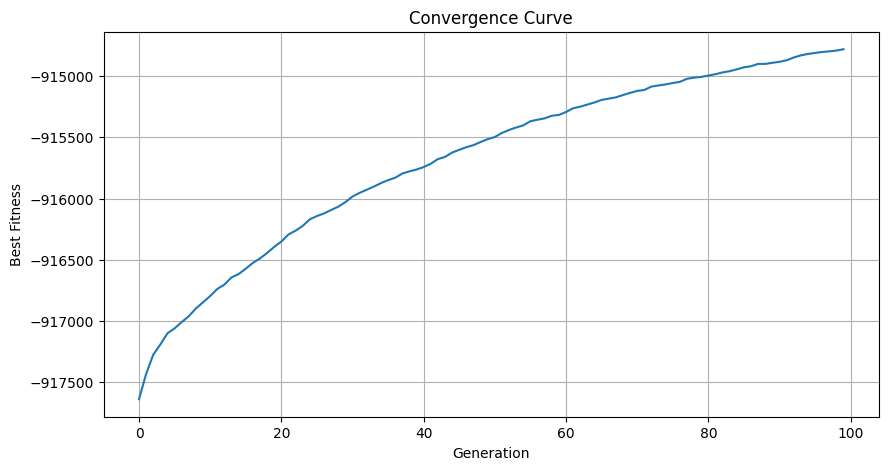

Execution time (parallel): 19.45 seconds


In [26]:
start = time.time()
fitness_log = run_ga(generations=100)
end = time.time()

plt.figure(figsize=(10, 5))
plt.plot(fitness_log)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence Curve")
plt.grid(True)
plt.show()

print(f"Execution time (parallel): {end - start:.2f} seconds")

In [29]:
def serial_fitness(pop, ga):
    print("Serial fitness: population shape =", pop.shape)  # Should be (N, 720)
    return np.array([ga.fitness(chrom) for chrom in pop])


def run_ga_serial(generations=50):
    ga = GA_EnergyOptimizer(**grid_data, pop_size=200)
    population = ga.initialize_population()
    best_fitness_per_gen = []

    for gen in range(generations):
        fitness = serial_fitness(population, ga)
        best_fitness_per_gen.append(np.max(fitness))
        top = selection(population, fitness)

        new_pop = []
        for _ in range(len(population)):
            child = crossover(*top)
            child = mutate(child, ga.mutation_rate)
            new_pop.append(child)
        population = np.array(new_pop)

        if gen % 10 == 0:
            print(f"Generation {gen}: Best fitness = {best_fitness_per_gen[-1]}")

    return best_fitness_per_gen

start = time.time()
serial_log = run_ga_serial()
end = time.time()

print(f"Execution time (serial): {end - start:.2f} seconds")

Population shape: (200, 720)
Serial fitness: population shape = (200, 720)
Generation 0: Best fitness = -559849.0174651641
Serial fitness: population shape = (200, 24, 720)


ValueError: cannot reshape array of size 17280 into shape (10,3,24)

In [30]:
ga = GA_EnergyOptimizer(**grid_data, pop_size=24)
population = ga.initialize_population()  # Should print (24, 720)

# Optional: validate chromosome length manually
assert population.shape[1] == ga.chrom_len

fitnesses = serial_fitness(population, ga)

Population shape: (24, 720)
Serial fitness: population shape = (24, 720)
